In [3]:
import matplotlib.pyplot as plt
import numpy as np
import math
%matplotlib inline

In [1]:
############################## Eq # 1. ##############################
# Basic equation #

def f(x):
    return 3*x**2 - 4*x + 5

In [2]:
f(3.0)

20.0

In [5]:
## Let's draw the equation.
xs = np.arange(-5, 5, .25)

In [7]:
ys = f(xs)

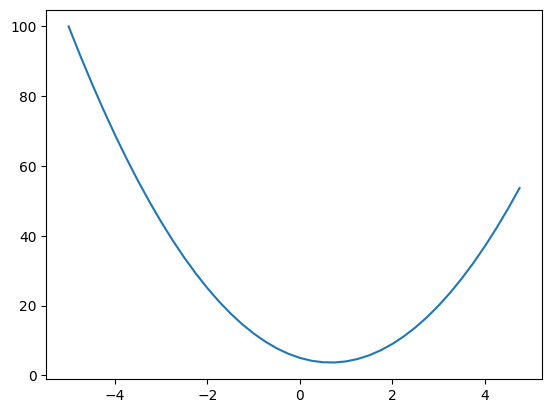

In [8]:
plt.plot(xs, ys)

In [10]:
############################## Eq # 2. ##############################
# Derivative #

In [11]:
def df(x, h=0.00000001):
    return (f(x + h) - f(x)) / h

In [12]:
df(3.0)

14.00000009255109

In [13]:
##### Since the derivative of 3x^2 - 4x + 5 is 6x - 4
##### Pluggin in will yield 6(3) - 4 = 14.

In [14]:
############################## Eq # 3. ##############################
# Complicated equations #

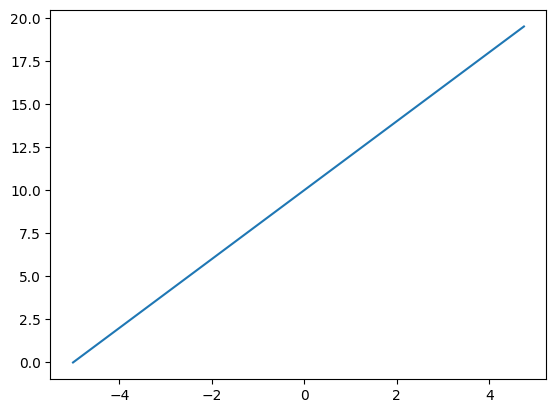

In [21]:
def cf(m, x, b):
    return m*x + b

xs = np.arange(-5, 5, .25)
ys = cf(2, xs, 10)

plt.plot(xs, ys)

In [18]:
h = 0.0001

m = 2.0
x = -3.0
b = 10.0

d1 = cf(m, x, b)

# Let's calc d1/dm or d2

d2 = cf(m, x + h, b)

grad = (d2 - d1) / h

d1, d2, grad

(4.0, 4.0002, 2.0000000000042206)

In [22]:
############################## Building Value Object. ##############################

In [ ]:
class Value:
    def __init__(self, data, childre=(), op='', label=''):
        self.data = data
        self._prev = set(children)
        self._op = _op
        self.label = label
        self._backward = lambda: None
        self.grad = 0